In [ ]:
import os
import random
import glob
import time
from collections import Counter

import gin
gin.enter_interactive_mode()
import numpy as np
import tensorflow as tf
import tensorflow_docs.vis.embed as embed
import matplotlib.pyplot as plt
import cv2
import imageio
from tensorflow.keras import layers

In [ ]:
@tf.keras.utils.register_keras_serializable(package='Custom', name='spectral_norm')
def spectral_norm(w, power_iteration=1):
    w_shape = w.shape.as_list()
    w = tf.reshape(w, [-1, w_shape[-1]])
    u = tf.random.normal([1, w_shape[-1]])
    u_hat = u
    v_hat = None
    for i in range(power_iteration):
        v_ = tf.matmul(u_hat, tf.transpose(w))
        v_hat = tf.nn.l2_normalize(v_)
        u_ = tf.matmul(v_hat, w)
        u_hat = tf.nn.l2_normalize(u_)
    sigma = tf.matmul(tf.matmul(v_hat, w), tf.transpose(u_hat))
    w_norm = w / sigma
    w_norm = tf.reshape(w_norm, w_shape)
    return w_norm

class NonLocalBlock(layers.Layer):
    def __init__(self, name, k_reg):
        super(NonLocalBlock, self).__init__(name='NonLocalBlock' + '_' + name)
        self.k_reg = k_reg
        b_init = tf.zeros_initializer()
        self.sigma = tf.Variable(initial_value=b_init(shape=[], dtype="float32"), trainable=True)

    def build(self, input_shape):
        h, w, num_channels = input_shape.as_list()[1:]
        self.h = h
        self.w = w
        self.num_channels = num_channels
        self.num_channels_attn = self.num_channels // 8
        self.num_channels_g = self.num_channels // 2
        self.conv2d_1 = layers.Conv2D(filters=self.num_channels_attn, kernel_size=(1, 1), use_bias=False, strides=(1, 1), padding='same', kernel_initializer=tf.initializers.orthogonal(), kernel_regularizer=self.k_reg, name="conv2d_theta")
        self.conv2d_2 = layers.Conv2D(filters=self.num_channels_attn, kernel_size=(1, 1), use_bias=False, strides=(1, 1), padding='same', kernel_initializer=tf.initializers.orthogonal(), kernel_regularizer=self.k_reg, name="conv2d_phi")
        self.conv2d_3 = layers.Conv2D(filters=self.num_channels_g, kernel_size=(1, 1), use_bias=False, strides=(1, 1), padding='same', kernel_initializer=tf.initializers.orthogonal(), kernel_regularizer=self.k_reg, name="conv2d_g")
        self.conv2d_4 = layers.Conv2D(filters=self.num_channels, kernel_size=(1, 1), use_bias=False, strides=(1, 1), padding='same', kernel_initializer=tf.initializers.orthogonal(), kernel_regularizer=self.k_reg, name="conv2d_attn_g")

    def _spatial_flatten(self, inputs):
        return tf.reshape(inputs, (tf.shape(inputs)[0], -1, inputs.shape[3]))

    def call(self, input):
        theta = self.conv2d_1(input)
        theta = self._spatial_flatten(theta)
        phi = self.conv2d_2(input)
        phi = layers.MaxPool2D(pool_size=[2, 2], strides=2)(phi)
        phi = self._spatial_flatten(phi)
        attn = tf.matmul(theta, phi, transpose_b=True)
        attn = tf.nn.softmax(attn)
        g = self.conv2d_3(input)
        g = layers.MaxPool2D(pool_size=[2, 2], strides=2)(g)
        g = self._spatial_flatten(g)
        attn_g = tf.matmul(attn, g)
        attn_g = tf.reshape(attn_g, [tf.shape(attn_g)[0], self.h, -1, self.num_channels_g])
        attn_g = self.conv2d_4(attn_g)
        return self.sigma * attn_g + input

class SpatialEmbedding(layers.Layer):
    def __init__(self, vocab_size, filter_dim):
        super(SpatialEmbedding, self).__init__(name='SpatialEmbedding')
        self.vocab_size = vocab_size
        self.filter_dim = filter_dim

    def build(self, input_shape):
        self.kernel = self.add_weight("filter_bank", shape=[self.vocab_size, self.filter_dim[0], self.filter_dim[1]], trainable=True)

    def call(self, inputs, **kwargs):
        return tf.nn.embedding_lookup(self.kernel, inputs)

class ConditionalBatchNorm(layers.Layer):
    def __init__(self, name, cbn_idx, conditioning_vector, k_reg):
        super(ConditionalBatchNorm, self).__init__(name='CBN' + '_' + name + '_' + str(cbn_idx))
        self.conditioning_vector = conditioning_vector
        self.k_reg = k_reg

    def call(self, inputs, **kwargs):
        net = layers.BatchNormalization(scale=False, center=False)(inputs)
        num_channels = net.shape[-1]
        gamma = layers.Dense(units=num_channels, use_bias=False, activation='linear', kernel_regularizer=self.k_reg, kernel_initializer=tf.initializers.orthogonal())(self.conditioning_vector)
        gamma = tf.reshape(gamma, [-1, 1, 1, num_channels])
        net *= gamma
        beta = layers.Dense(units=num_channels, use_bias=False, activation='linear', kernel_regularizer=self.k_reg, kernel_initializer=tf.initializers.orthogonal())(self.conditioning_vector)
        beta = tf.reshape(beta, [-1, 1, 1, num_channels])
        net += beta
        return net

class ResNetBlockUp(layers.Layer):
    def __init__(self, name, output_dim, is_last_block, conditioning_vector, k_reg):
        super(ResNetBlockUp, self).__init__(name='ResNetBlockUp' + '_' + name)
        self.nm = name
        self.output_dim = output_dim
        self.is_last_block = is_last_block
        self.conditioning_vector = conditioning_vector
        self.k_reg = k_reg

    def call(self, inputs, **kwargs):
        net = inputs
        net = ConditionalBatchNorm(self.nm, 1, self.conditioning_vector, self.k_reg).call(net)
        net = tf.nn.relu(net)
        up_stride = (2, 1) if self.is_last_block else (2, 2)
        net = layers.Conv2DTranspose(self.output_dim, (3, 3), strides=up_stride, kernel_regularizer=self.k_reg, kernel_initializer=tf.initializers.orthogonal(), padding='same', use_bias=True)(net)
        net = ConditionalBatchNorm(self.nm, 2, self.conditioning_vector, self.k_reg).call(net)
        net = tf.nn.relu(net)
        net = layers.Conv2D(self.output_dim, (3, 3), strides=(1, 1), kernel_initializer=tf.initializers.orthogonal(), kernel_regularizer=self.k_reg, padding='same', use_bias=True)(net)
        shortcut = layers.Conv2DTranspose(self.output_dim, (1, 1), strides=up_stride, kernel_initializer=tf.initializers.orthogonal(), kernel_regularizer=self.k_reg, padding='same', use_bias=True)(inputs)
        net += shortcut
        return net

class ResNetBlockDown(layers.Layer):
    def __init__(self, name, output_dim, is_last_block, k_reg):
        super(ResNetBlockDown, self).__init__(name='ResNetBlockDown' + '_' + name)
        self.nm = name
        self.output_dim = output_dim
        self.is_last_block = is_last_block
        self.k_reg = k_reg

    def call(self, inputs, **kwargs):
        net = inputs
        net = tf.nn.relu(net)
        net = layers.Conv2D(self.output_dim, (3, 3), strides=(1, 1), kernel_initializer=tf.initializers.orthogonal(), kernel_regularizer=self.k_reg, padding='same', use_bias=True)(net)
        net = tf.nn.relu(net)
        net = layers.Conv2D(self.output_dim, (3, 3), strides=(1, 1), kernel_initializer=tf.initializers.orthogonal(), kernel_regularizer=self.k_reg, padding='same', use_bias=True)(net)
        if not self.is_last_block:
            net = tf.nn.pool(net, window_shape=[2, 2], pooling_type="AVG", padding="SAME", strides=[2, 2])
        shortcut = layers.Conv2D(self.output_dim, (1, 1), strides=(1, 1), kernel_initializer=tf.initializers.orthogonal(), kernel_regularizer=self.k_reg, padding='same', use_bias=True)(inputs)
        if not self.is_last_block:
            shortcut = tf.nn.pool(shortcut, window_shape=[2, 2], pooling_type="AVG", padding="SAME", strides=[2, 2])
        net += shortcut
        return net

def not_saturating(d_real_logits, d_fake_logits):
    d_loss_real = tf.nn.sigmoid_cross_entropy_with_logits(logits=d_real_logits, labels=tf.ones_like(d_real_logits))
    d_loss_fake = tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits, labels=tf.zeros_like(d_fake_logits))
    d_loss = d_loss_real + d_loss_fake
    g_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits, labels=tf.ones_like(d_fake_logits))
    return d_loss, d_loss_real, d_loss_fake, g_loss

def hinge(d_real_logits, d_fake_logits):
    d_loss_real = tf.nn.relu(1.0 - d_real_logits)
    d_loss_fake = tf.nn.relu(1.0 + d_fake_logits)
    d_loss = d_loss_real + d_loss_fake
    g_loss = -d_fake_logits
    return d_loss, d_loss_real, d_loss_fake, g_loss

def get_in_out_channels_gen(resolution=32):
    ch = 64
    channel_multipliers = [8, 4, 2, 1] if resolution == 32 else [1]
    in_channels = [ch * c for c in channel_multipliers[:-1]]
    out_channels = [ch * c for c in channel_multipliers[1:]]
    return in_channels, out_channels

def get_in_out_channels_disc(colors=1, resolution=32):
    ch = 64
    channel_multipliers = [1, 8, 16, 16] if resolution == 32 else [1]
    out_channels = [ch * c for c in channel_multipliers]
    in_channels = [colors] + out_channels[:-1]
    return in_channels, out_channels

def make_recognizer(input_dim, sequence_length, output_classes, gen_path, vis_model=True):
    h, w, c = input_dim
    w = None
    inp_imgs = layers.Input(shape=(h, w, c), name='input_images')
    conv_1 = layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same', strides=1)(inp_imgs)
    pool_1 = layers.MaxPool2D(pool_size=(2, 2))(conv_1)
    conv_2 = layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same', strides=1)(pool_1)
    pool_2 = layers.MaxPool2D(pool_size=(2, 2))(conv_2)
    conv_3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same', strides=1)(pool_2)
    conv_4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same', strides=1)(conv_3)
    pool_4 = layers.MaxPool2D(pool_size=(2, 1))(conv_4)
    conv_5 = layers.Conv2D(filters=512, kernel_size=3, activation='relu', padding='same', strides=1)(pool_4)
    batch_norm_5 = layers.BatchNormalization()(conv_5)
    conv_6 = layers.Conv2D(filters=512, kernel_size=3, activation='relu', padding='same', strides=1)(batch_norm_5)
    batch_norm_6 = layers.BatchNormalization()(conv_6)
    pool_6 = layers.MaxPool2D(pool_size=(2, 1))(batch_norm_6)
    conv_7 = layers.Conv2D(filters=512, kernel_size=2, activation='relu', padding='valid', strides=1)(pool_6)
    map_to_seq = layers.Lambda(lambda x: tf.keras.backend.squeeze(x, 1))(conv_7)
    per_frame_predictions = tf.keras.layers.Dense(output_classes, activation='softmax')(map_to_seq)
    def ctc_loss(args):
        y_true, y_pred, input_length, label_length = args
        return tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    labels = layers.Input(name='y_true', shape=[sequence_length], dtype='float32')
    input_length = layers.Input(shape=[1], dtype=tf.int32, name='input_length')
    label_length = layers.Input(name='label_length', shape=[1], dtype=tf.int32)
    loss_out = tf.keras.layers.Lambda(ctc_loss, output_shape=(1,), name='ctc')([labels, per_frame_predictions, input_length, label_length])
    model = tf.keras.Model(inputs=[inp_imgs, labels, input_length, label_length], outputs=loss_out)
    if vis_model: model.summary()
    return model

def make_generator(latent_dim, input_dim, embed_y, gen_path, kernel_reg, blocks_with_attention, vocab_size, vis_model=True):
    h, _, c = input_dim
    in_channels, out_channels = get_in_out_channels_gen(h)
    num_blocks = len(in_channels)
    seed_size_h = int(h / 2 ** num_blocks)
    seed_size_w = seed_size_h
    z = layers.Input(shape=(latent_dim,))
    y = layers.Input(shape=(None,), dtype=tf.int32)
    spatial_embedding = SpatialEmbedding(vocab_size=vocab_size, filter_dim=embed_y)
    se_layer = spatial_embedding(y)
    z_per_block = tf.split(z, num_blocks + 1, axis=1)
    z0, z_per_block = z_per_block[0], z_per_block[1:]
    z0 = tf.reshape(z0, (-1, 1, 1, z0.shape[1]))
    net = tf.linalg.matmul(tf.tile(z0, [1, tf.shape(se_layer)[1], 1, 1]), se_layer)
    net = tf.squeeze(net, axis=2)
    net = tf.reshape(net, (tf.shape(net)[0], 512, seed_size_h, seed_size_w, -1))
    net = tf.reshape(net, (tf.shape(net)[0], -1, 512, seed_size_h))
    net = tf.transpose(net, (0, 3, 1, 2))
    for block_idx in range(num_blocks):
        name = "B{}".format(block_idx + 1)
        is_last_block = block_idx == num_blocks - 1
        net = ResNetBlockUp(name, out_channels[block_idx], is_last_block, z_per_block[block_idx], kernel_reg).call(net)
        if name in blocks_with_attention:
            net = NonLocalBlock(name, kernel_reg)(net)
    net = layers.BatchNormalization()(net)
    net = tf.nn.relu(net)
    net = layers.Conv2D(c, (3, 3), strides=(1, 1), kernel_initializer=tf.initializers.orthogonal(), kernel_regularizer=kernel_reg, padding='same')(net)
    net = tf.nn.tanh(net)
    model = tf.keras.Model([z, y], net)
    if vis_model: model.summary()
    return model

def make_discriminator(gen_path, input_dim, kernel_reg, blocks_with_attention, vis_model=True):
    h, w, c = input_dim
    w = None
    in_channels, out_channels = get_in_out_channels_disc(colors=c, resolution=h)
    num_blocks = len(in_channels)
    x = layers.Input(shape=(h, w, c))
    net = x
    for block_idx in range(num_blocks):
        name = "B{}".format(block_idx + 1)
        is_last_block = block_idx == num_blocks - 1
        net = ResNetBlockDown(name, out_channels[block_idx], is_last_block, kernel_reg).call(net)
        if name in blocks_with_attention:
            net = NonLocalBlock(name, kernel_reg)(net)
    net = tf.nn.relu(net)
    net_h = layers.GlobalAveragePooling2D()(net)
    out_logit = layers.Dense(units=1, use_bias=False, activation='linear', kernel_regularizer=kernel_reg, kernel_initializer=tf.initializers.orthogonal())(net_h)
    model = tf.keras.Model([x], [out_logit])
    if vis_model: model.summary()
    return model

def make_gan(g_model, d_model, r_model, gen_path, vis_model=True):
    d_model.trainable = False
    r_model.trainable = False
    input_length = layers.Input(shape=[1], dtype=tf.int32, name='input_length')
    label_length = layers.Input(name='label_length', shape=[1], dtype=tf.int32)
    gan_output_d = d_model(g_model.output, training=True)
    gan_output_r = r_model([g_model.output, g_model.input[1], input_length, label_length], training=True)
    model = tf.keras.Model(g_model.input + [input_length, label_length], [g_model.output, gan_output_d, gan_output_r])
    if vis_model: model.summary()
    return model

def convert_to_gan_reading_format_save(input_dir, output_dir, target_size, bucket_size, apply_preprocessing=False):
    """
    Converts IAM DB to the format needed for the GAN.
    Includes an option to apply morphological closing for preprocessing.
    """
    h, w, _ = target_size

    if apply_preprocessing:

        final_output_dir = output_dir.rstrip('/') + '-preprocessed/'
        print(f"Applying preprocessing. Output will be saved to: {final_output_dir}")
    else:
        final_output_dir = output_dir
        print(f"No preprocessing applied. Output will be saved to: {final_output_dir}")

    if not os.path.exists(final_output_dir):
        for i in range(bucket_size):
            os.makedirs(os.path.join(final_output_dir, str(i + 1)))

    transcriptions = {}
    words_txt_path = os.path.join(os.path.dirname(input_dir.rstrip('/')), 'words.txt')
    try:
        with open(words_txt_path, 'r') as f:
            for line in f:
                if not line.startswith('#'):
                    parts = line.strip().split()
                    if len(parts) > 8 and parts[1] == 'ok':
                        img_name = f"{parts[0]}.png"
                        transcription = parts[-1]
                        transcriptions[img_name] = transcription
    except FileNotFoundError:
        print(f"Error: 'words.txt' not found at {words_txt_path}")
        return

    listOfFiles = []
    for (dirpath, _, filenames) in os.walk(input_dir):
        listOfFiles += [os.path.join(dirpath, file) for file in filenames if file.endswith(".png")]

    valid_samples = 0
    transcription_lengths = []

    for idx, file_path in enumerate(listOfFiles):
        img_nm = os.path.basename(file_path)
        if img_nm in transcriptions:
            transcription = transcriptions[img_nm]
            if transcription.isalpha() and 0 < len(transcription) <= bucket_size:
                img = cv2.imread(file_path, 0)
                if img is None:
                    print(f"Warning: Could not read image {file_path}")
                    continue

                try:
                    processed_img = img
                    if apply_preprocessing:
                        kernel = np.ones((2, 2), np.uint8)
                        processed_img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)

                    len_word = len(transcription)
                    resized_img = cv2.resize(processed_img, (int(h / 2) * len_word, h))

                    output_bucket_path = os.path.join(final_output_dir, str(len_word))
                    cv2.imwrite(os.path.join(output_bucket_path, img_nm), resized_img)

                    with open(os.path.join(output_bucket_path, os.path.splitext(img_nm)[0] + '.txt'), 'w', encoding="utf8") as fo:
                        fo.write(transcription)

                    valid_samples += 1
                    transcription_lengths.append(len_word)
                except Exception as e:
                    print(f'Error processing file {file_path}: {e}')

    print(f'\nFinished processing. Total valid samples: {valid_samples}')
    print("Sample distribution across buckets:")
    print(Counter(sorted(transcription_lengths)))

def init_reading(train_input, train_output, target_size, bucket_size, apply_preprocessing=False):
    print('Converting iamDB words to GAN-Reading task...\n')
    convert_to_gan_reading_format_save(train_input, train_output, target_size, bucket_size, apply_preprocessing)

def load_random_word_list(reading_dir, bucket_size, char_vector):
    random_words = [[] for _ in range(bucket_size)]

    random_words_path = os.path.join(os.path.dirname(os.path.dirname(reading_dir.rstrip('/'))), 'random_words.txt')
    if not os.path.exists(random_words_path):

        random_words_path_alt = os.path.join(os.path.dirname(reading_dir.rstrip('/')), 'random_words.txt')
        if os.path.exists(random_words_path_alt):
            random_words_path = random_words_path_alt
        else:
            print(f"Warning: random_words.txt not found at {random_words_path} or {random_words_path_alt}")
            return random_words

    with open(random_words_path, 'r') as fi:
        for word in fi:
            word = word.strip()
            if word and word.isalpha() and len(word) <= bucket_size:
                try:
                    random_words[len(word) - 1].append([char_vector.index(char) for char in word])
                except ValueError as e:

                    pass
    return random_words

def load_prepare_data(input_dim, batch_size, reading_dir, char_vector, bucket_size):
    h, w, c = input_dim
    data_buckets = {}
    bucket_weights = {}
    number_samples = 0

    print(f"Loading data from buckets in: {reading_dir}")
    for i in range(1, bucket_size + 1):
        imgs, labels = [], []
        reading_dir_bucket = os.path.join(reading_dir, str(i))
        if not os.path.exists(reading_dir_bucket): continue

        file_list = [f for f in os.listdir(reading_dir_bucket) if f.endswith(".txt")]
        for file in file_list:
            try:
                with open(os.path.join(reading_dir_bucket, file), 'r', encoding='utf8') as f:
                    label_text = f.readline().strip()
                    if not label_text: continue
                    label = [char_vector.index(char) for char in label_text]

                img_path = os.path.join(reading_dir_bucket, os.path.splitext(file)[0] + '.png')
                img = cv2.imread(img_path, 0)

                if img is not None:
                    imgs.append(img)
                    labels.append(label)
                else:
                    print(f"Warning: Failed to load image {img_path}")

            except Exception as e:
                print(f"Error loading sample {file}: {e}")

        if imgs:
            data_buckets[i] = (imgs, labels)
            number_samples += len(labels)

    if number_samples == 0:
        raise ValueError(f"No samples found in '{reading_dir}'. Check your data directory and preprocessing steps.")

    for i in range(1, bucket_size + 1):
        bucket_weights[i] = len(data_buckets.get(i, ([], []))[1]) / number_samples if number_samples > 0 else 0

    bucket_indices = list(bucket_weights.keys())
    bucket_probabilities = list(bucket_weights.values())

    while True:

        random_bucket_idx = np.random.choice(bucket_indices, 1, p=bucket_probabilities)[0]

        image_batch, label_batch = [], []
        if not data_buckets[random_bucket_idx][1]: continue

        for _ in range(batch_size):
            sample_idx = random.randint(0, len(data_buckets[random_bucket_idx][1]) - 1)
            image_batch.append(data_buckets[random_bucket_idx][0][sample_idx])
            label_batch.append(data_buckets[random_bucket_idx][1][sample_idx])

        image_batch = np.array(image_batch, dtype='float32')
        label_batch = np.array(label_batch, dtype=np.int32)

        current_width = int((h / 2) * random_bucket_idx)
        image_batch = image_batch.reshape(-1, h, current_width, c)
        image_batch = (image_batch - 127.5) / 127.5

        yield (image_batch, label_batch)

def generate_and_save_images(model, epoch, test_input, gen_path, char_vector):
    predictions = model(test_input, training=False)
    predictions = (predictions + 1) / 2.0
    labels = test_input[1]

    plt.figure(figsize=(10, 10))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.text(0, -1, "".join([char_vector[label] for label in labels[i]]))
        plt.axis('off')
    if not os.path.exists(gen_path): os.makedirs(gen_path)
    plt.savefig(os.path.join(gen_path, f'image_at_epoch_{epoch:04d}.png'))
    plt.close()

def train_step(epoch_idx, batch_idx, batch_per_epoch, images, labels, discriminator, recognizer, composite_gan, generator_optimizer, discriminator_optimizer, recognizer_optimizer, batch_size, latent_dim, loss_fn, disc_iters, random_words, bucket_size):
    noise = tf.random.normal([batch_size, latent_dim])

    valid_buckets = [i for i, words in enumerate(random_words) if words]
    if not valid_buckets:
        print("Warning: No random words available for training step.")
        return
    random_bucket_idx = random.choice(valid_buckets)

    fake_labels = np.array([random.choice(random_words[random_bucket_idx]) for _ in range(batch_size)], np.int32)

    batch_size_real = images.shape[0]
    sequence_length_real = len(labels[0])
    sequence_length_fake = random_bucket_idx + 1

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape, tf.GradientTape() as rec_tape:
        inp_len_fake = -1 + sequence_length_fake * 4
        gen_images, d_fake_logits, r_fake_logits = composite_gan([noise, fake_labels, np.array([[inp_len_fake]] * batch_size), np.array([[sequence_length_fake]] * batch_size)], training=True)

        d_real_logits = discriminator([images], training=True)

        inp_len_real = -1 + sequence_length_real * 4
        r_real_logits = recognizer([images, labels, np.array([[inp_len_real]] * batch_size_real), np.array([[sequence_length_real]] * batch_size_real)], training=True)

        d_loss, d_loss_real, d_loss_fake, g_loss = loss_fn(d_real_logits, d_fake_logits)

        g_loss_balanced = g_loss + r_fake_logits

        r_loss_fake_mean = tf.reduce_mean(r_fake_logits)
        r_loss_real_mean = tf.reduce_mean(r_real_logits)
        g_loss_mean = tf.reduce_mean(g_loss)
        d_loss_mean = tf.reduce_mean(d_loss)
        g_loss_balanced_mean = tf.reduce_mean(g_loss_balanced)

    tf.print(f'>{epoch_idx+1}, {batch_idx+1}/{batch_per_epoch}, d={d_loss_mean:.3f}, g_trad={g_loss_mean:.3f}, r_fake={r_loss_fake_mean:.3f}, g_balanced={g_loss_balanced_mean:.3f}, r_real={r_loss_real_mean:.3f}')

    discriminator.trainable = True
    gradients_of_discriminator = disc_tape.gradient(d_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    recognizer.trainable = True
    gradients_of_recognizer = rec_tape.gradient(r_real_logits, recognizer.trainable_variables)
    recognizer_optimizer.apply_gradients(zip(gradients_of_recognizer, recognizer.trainable_variables))

    if (batch_idx + 1) % disc_iters == 0:
        recognizer.trainable = False
        discriminator.trainable = False
        gradients_of_generator = gen_tape.gradient(g_loss_balanced, composite_gan.trainable_variables)
        generator_optimizer.apply_gradients(zip(gradients_of_generator, composite_gan.trainable_variables))

def train(dataset, generator, discriminator, recognizer, composite_gan, checkpoint, checkpoint_prefix, generator_optimizer, discriminator_optimizer, recognizer_optimizer, seed_labels, buffer_size, batch_size, epochs, model_path, latent_dim, gen_path, loss_fn, disc_iters, random_words, bucket_size, char_vector):
    batch_per_epoch = int(buffer_size / batch_size)
    print('Training starting...')
    for epoch_idx in range(epochs):
        start = time.time()
        for batch_idx in range(batch_per_epoch):
            image_batch, label_batch = next(dataset)
            train_step(epoch_idx, batch_idx, batch_per_epoch, image_batch, label_batch, discriminator, recognizer, composite_gan, generator_optimizer, discriminator_optimizer, recognizer_optimizer, batch_size, latent_dim, loss_fn, disc_iters, random_words, bucket_size)

        generate_and_save_images(generator, epoch_idx + 1, seed_labels, gen_path, char_vector)

        if (epoch_idx + 1) % 5 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        print(f'Time for epoch {epoch_idx + 1} is {time.time() - start:.2f} sec')

    if not os.path.exists(model_path): os.makedirs(model_path)
    generator.save(os.path.join(model_path, f'generator_{epochs}'), save_format='tf')

def make_gif(gen_path):
    if not os.path.exists(gen_path): os.makedirs(gen_path)
    anim_file = os.path.join(gen_path, 'gan_training.gif')
    with imageio.get_writer(anim_file, mode='I') as writer:
        filenames = sorted(glob.glob(os.path.join(gen_path, 'image*.png')))
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)
        if filenames:
            writer.append_data(imageio.imread(filenames[-1]))

In [ ]:
gin.external_configurable(hinge)
gin.external_configurable(not_saturating)
gin.external_configurable(spectral_norm)

@gin.configurable
def setup_optimizer(g_lr, d_lr, r_lr, beta_1, beta_2, loss_fn, disc_iters):
    generator_optimizer = tf.keras.optimizers.Adam(learning_rate=g_lr, beta_1=beta_1, beta_2=beta_2)
    discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=d_lr, beta_1=beta_1, beta_2=beta_2)
    recognizer_optimizer = tf.keras.optimizers.Adam(learning_rate=r_lr, beta_1=beta_1, beta_2=beta_2)
    return generator_optimizer, discriminator_optimizer, recognizer_optimizer, loss_fn, disc_iters

@gin.configurable('shared_specs')
def get_shared_specs(epochs, batch_size, latent_dim, embed_y, num_gen, kernel_reg, g_bw_attention, d_bw_attention):
    return epochs, batch_size, latent_dim, embed_y, num_gen, kernel_reg, g_bw_attention, d_bw_attention

@gin.configurable('io')
def setup_io(base_path, checkpoint_dir, gen_imgs_dir, model_dir, raw_dir, read_dir, input_dim, buf_size, n_classes,
             seq_len, char_vec, bucket_size):

    gen_path = os.path.join(base_path, gen_imgs_dir.strip('/\\'))
    ckpt_path = os.path.join(base_path, checkpoint_dir.strip('/\\'))
    m_path = os.path.join(base_path, model_dir.strip('/\\'))
    raw_dir_path = os.path.join(base_path, raw_dir.strip('/\\'))
    read_dir_path = os.path.join(base_path, read_dir.strip('/\\'))
    return input_dim, buf_size, n_classes, seq_len, bucket_size, ckpt_path, gen_path, m_path, raw_dir_path, read_dir_path, char_vec

print("Gin Configurables Registered")


Gin Configurables Registered


In [ ]:
gin_config_string = """
# Loss and Optimizer (AdamOptimizer for both G, D and R)
setup_optimizer.g_lr = 2E-4
setup_optimizer.d_lr = 2E-4
setup_optimizer.r_lr = 2E-4
setup_optimizer.beta_1 = 0.0
setup_optimizer.beta_2 = 0.999
setup_optimizer.loss_fn = @not_saturating
setup_optimizer.disc_iters = 1

# Shared specs (G and D)
shared_specs.epochs = 15
shared_specs.batch_size = 16
shared_specs.latent_dim = 128
shared_specs.embed_y = (32, 8192)
shared_specs.num_gen = 16
shared_specs.kernel_reg = @spectral_norm
shared_specs.g_bw_attention = 'B3'
shared_specs.d_bw_attention = 'B1'

# I/O and data structure
io.base_path = '.'
io.checkpoint_dir = 'res/out/big_ac_gan/training_checkpoints'
io.gen_imgs_dir = 'res/out/big_ac_gan/images/'
io.model_dir = 'res/out/big_ac_gan/model/'

# Dataset
io.input_dim = (32, 160, 1)
io.buf_size = 80377
io.n_classes = 52
io.seq_len = None
io.bucket_size = 10
io.raw_dir = 'res/data/iamDB/words/'
io.read_dir = 'res/data/iamDB/words-Reading/'
io.char_vec = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'
"""

gin.parse_config(gin_config_string)


epochs, batch_size, latent_dim, embed_y, num_gen, kernel_reg, g_bw_attention, d_bw_attention = get_shared_specs()
in_dim, buf_size, n_classes, seq_len, bucket_size, ckpt_path, gen_path, m_path, raw_dir, read_dir, char_vec = setup_io()

print("Parameters Loaded")
print(f"Epochs: {epochs}, Batch Size: {batch_size}")
print(f"Raw Data Directory: {raw_dir}")
print(f"Checkpoint Path: {ckpt_path}")

Parameters Loaded
Epochs: 15, Batch Size: 16
Raw Data Directory: .\res/data/iamDB/words
Checkpoint Path: .\res/out/big_ac_gan/training_checkpoints


In [ ]:
if not os.path.exists(read_dir):
      print('Converting iamDB-Dataset to GAN format with preprocessing...')
      init_reading(raw_dir, read_dir, in_dim, bucket_size)

random_words = load_random_word_list(read_dir, bucket_size, char_vec)

preprocessed_read_dir = read_dir.rstrip('/')
train_dataset = load_prepare_data(in_dim, batch_size, preprocessed_read_dir, char_vec, bucket_size)

print("\nDataset Ready")


Dataset Ready


In [ ]:
vis_model=True

generator = make_generator(latent_dim, in_dim, embed_y, gen_path, kernel_reg, g_bw_attention, n_classes)
discriminator = make_discriminator(gen_path, in_dim, kernel_reg, d_bw_attention)
recognizer = make_recognizer(in_dim, seq_len, n_classes + 1, gen_path)

gan = make_gan(generator, discriminator, recognizer, gen_path)

generator_optimizer, discriminator_optimizer, recognizer_optimizer, loss_fn, disc_iters = setup_optimizer()

checkpoint_prefix = os.path.join(ckpt_path, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 recognizer_optimizer=recognizer_optimizer,
                                 generator=generator,
                                 discriminator=discriminator,
                                 recognizer=recognizer)

print("Models Built")

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 SpatialEmbedding (SpatialEmbed  (None, None, 32, 81  13631488   ['input_2[0][0]']                
 ding)                          92)                                                               
                                                                                                  
 tf.split (TFOpLambda)          [(None, 32),         0           ['input_1[0][0]']            

In [ ]:
import sys
import traceback
print("--- Starting Training (Redirecting output to 'train.log') ---")
log_file = open('train_preprocessed.log', 'w')
sys.stdout = log_file
sys.stderr = log_file
try:
    seed = tf.random.normal([num_gen, latent_dim])

    valid_buckets_for_seed = [i for i, words in enumerate(random_words) if words and len(words[0]) > 4]
    random_bucket_idx = random.choice(valid_buckets_for_seed) if valid_buckets_for_seed else 0
    labels = np.array([random.choice(random_words[random_bucket_idx]) for _ in range(num_gen)], np.int32)

    train(train_dataset, generator, discriminator, recognizer, gan, checkpoint, checkpoint_prefix, generator_optimizer,
          discriminator_optimizer, recognizer_optimizer, [seed, labels], buf_size, batch_size, epochs, m_path,
          latent_dim, gen_path, loss_fn, disc_iters, random_words, bucket_size, char_vec)

except Exception as e:
    print("\n--- !!! TRAINING CRASHED !!! ---")
    print(e)
    traceback.print_exc(file=sys.stdout)
finally:
    sys.stdout = sys.__stdout__
    sys.stderr = sys.__stderr__
    log_file.close()

C:\Users\j3n0zydes\AppData\Local\Temp\ipykernel_54464\3392547338.py:509: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
C:\Users\j3n0zydes\AppData\Local\Temp\ipykernel_54464\3392547338.py:512: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(filenames[-1]))



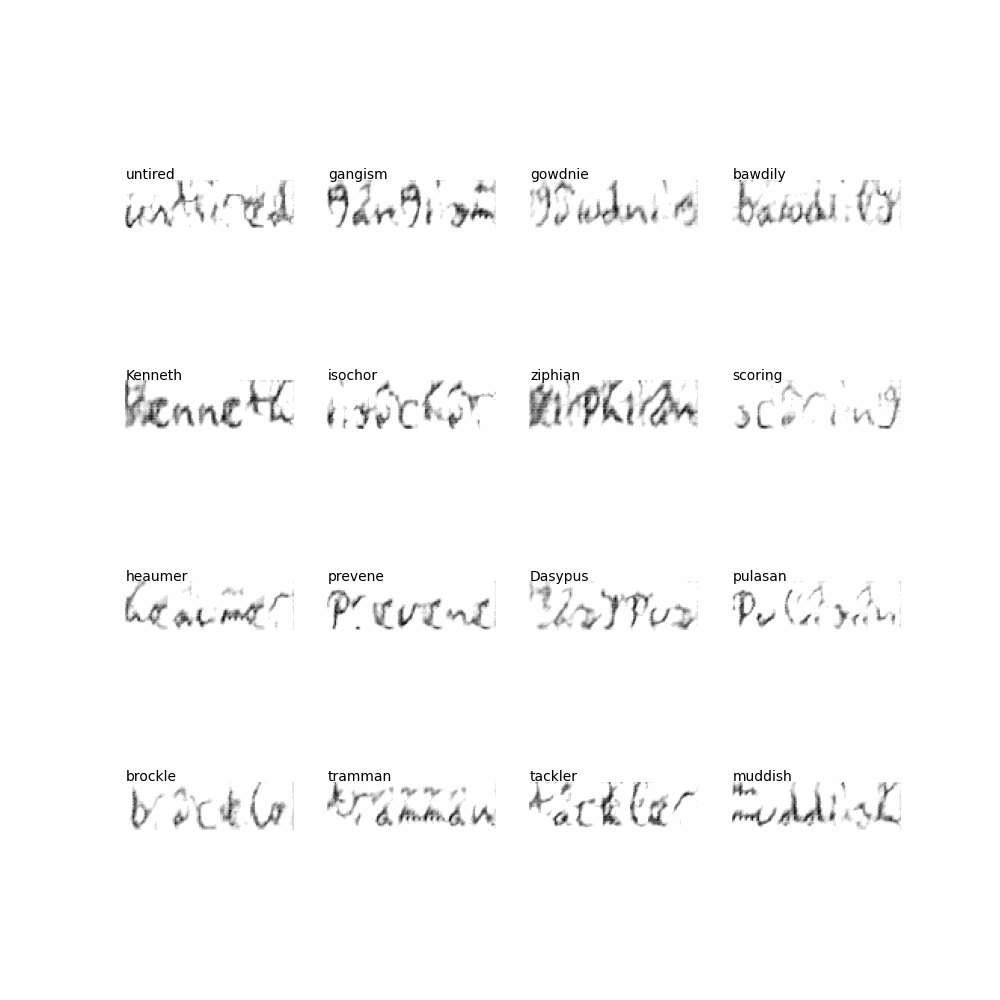

In [ ]:
make_gif(gen_path)
embed.embed_file(os.path.join(gen_path, 'gan_training.gif'))

Loading model from: .\res/out/big_ac_gan/model\generator_15

Generated images for 'ComputerVision'


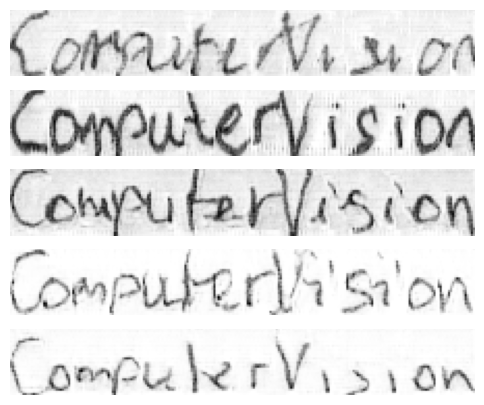

In [ ]:
path_to_saved_model = os.path.join(m_path, f'generator_{epochs}')

n_samples = 5
sample_string = 'ComputerVision'

print(f"Loading model from: {path_to_saved_model}")
imported_model = tf.saved_model.load(path_to_saved_model)

fake_labels = []
words = [sample_string] * n_samples
noise = tf.random.normal([n_samples, latent_dim])

for word in words:
  fake_labels.append([char_vec.index(char) for char in word])
fake_labels = np.array(fake_labels, np.int32)

predictions = imported_model([noise, fake_labels], training=False)
predictions = (predictions + 1) / 2.0

print(f"\nGenerated images for '{sample_string}'")
plt.figure(figsize=(15, n_samples))
for i in range(predictions.shape[0]):
  plt.subplot(n_samples, 1, i + 1)
  plt.imshow(predictions[i, :, :, 0], cmap='gray')
  plt.axis('off')
plt.show()

Loading model from: .\res/out/big_ac_gan/model\generator_15_preprocessing

Generated images for 'ComputerVision'


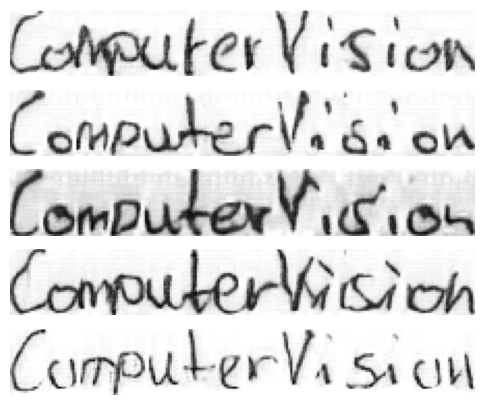

In [ ]:
path_to_saved_model = os.path.join(m_path, f'generator_{epochs}_preprocessing')

n_samples = 5
sample_string = 'ComputerVision'

print(f"Loading model from: {path_to_saved_model}")
imported_model = tf.saved_model.load(path_to_saved_model)

fake_labels = []
words = [sample_string] * n_samples
noise = tf.random.normal([n_samples, latent_dim])

for word in words:
  fake_labels.append([char_vec.index(char) for char in word])
fake_labels = np.array(fake_labels, np.int32)

predictions = imported_model([noise, fake_labels], training=False)
predictions = (predictions + 1) / 2.0

print(f"\nGenerated images for '{sample_string}'")
plt.figure(figsize=(15, n_samples))
for i in range(predictions.shape[0]):
  plt.subplot(n_samples, 1, i + 1)
  plt.imshow(predictions[i, :, :, 0], cmap='gray')
  plt.axis('off')
plt.show()

In [ ]:
import pytesseract
from PIL import Image
import numpy as np
import os
import sys

pytesseract.pytesseract.tesseract_cmd = 'C:\\Program Files\\Tesseract-OCR\\tesseract.exe'


test_words = ['Kenneth', 'Computer', 'Vision', 'ScrabbleGAN', 'handwriting', 'analysis', 'Morphological', 'Closing', 'baseline', 'experiment']

model_A_path = os.path.join(m_path, 'generator_15')
model_B_path = os.path.join(m_path, 'generator_15_preprocessing')

print(f"Loading Model A (Baseline) from: {model_A_path}")
print(f"Loading Model B (Preprocessed) from: {model_B_path}")

try:
    model_A = tf.saved_model.load(model_A_path)
    model_B = tf.saved_model.load(model_B_path)
    print("Models loaded successfully.")
except Exception as e:
    print(f"ERROR: Could not load one or both models. Please check the paths.")
    print(f"Error details: {e}")
    raise e

def calculate_wer(model, model_name, words):
    print(f"\n--- Testing {model_name} ---")
    total_errors = 0
    total_words = len(words)

    original_stderr = sys.stderr
    sys.stderr = open(os.devnull, 'w')

    for i, word in enumerate(words):
        try:
            label_list = [[char_vec.index(char) for char in word]]
            label_array = np.array(label_list, np.int32)

            noise = tf.random.normal([1, latent_dim])

            prediction = model([noise, label_array], training=False)
            prediction = ((prediction + 1) / 2.0).numpy() * 255
            img = prediction[0, :, :, 0].astype(np.uint8)

            pil_img = Image.fromarray(img)
            ocr_text = pytesseract.image_to_string(pil_img, config='--psm 7').strip()

            ground_truth = word

            if ocr_text != ground_truth:
                total_errors += 1
                print(f"Word: '{ground_truth}', OCR Result: '{ocr_text}'  (ERROR)")
            else:
                print(f"Word: '{ground_truth}', OCR Result: '{ocr_text}'  (OK)")

        except ValueError as e:
            print(f"Warning: Character in '{word}' not in char_vec. Skipping. Error: {e}")
            total_words -= 1
            continue
        except Exception as e:
            print(f"An error occurred processing word '{word}': {e}")
            total_errors += 1

    # Restore stderr
    sys.stderr.close()
    sys.stderr = original_stderr

    if total_words == 0:
        print("No valid test words were processed.")
        return 0.0

    wer = (total_errors / total_words) * 100
    print(f"Total Errors: {total_errors}/{total_words}")
    print(f"WER for {model_name}: {wer:.2f}%")
    return wer

wer_A = calculate_wer(model_A, "Model A (Baseline)", test_words)
print("-" * 20)
wer_B = calculate_wer(model_B, "Model B (Preprocessed)", test_words)
print("-" * 20)

print("\nQUANTITATIVE RESULTS")
print(f"Model A (Baseline) WER:    {wer_A:.2f}%")
print(f"Model B (Preprocessed) WER: {wer_B:.2f}%")
print("-" * 20)

if wer_B < wer_A:
    print("\nConclusion: Model B (Preprocessed) is quantitatively BETTER.")
elif wer_B == wer_A:
     print("\nConclusion: No significant quantitative difference observed.")
else:
    print("\nConclusion: Model B (Preprocessed) is quantitatively WORSE.")

Loading Model A (Baseline) from: .\res/out/big_ac_gan/model\generator_15
Loading Model B (Preprocessed) from: .\res/out/big_ac_gan/model\generator_15_preprocessing
Models loaded successfully.

--- Testing Model A (Baseline) ---
Word: 'Kenneth', OCR Result: 'Lonne'  (ERROR)
Word: 'Computer', OCR Result: 'Compuiter'  (ERROR)
Word: 'Vision', OCR Result: 'Veitioa'  (ERROR)
Word: 'ScrabbleGAN', OCR Result: 'Ccrabh le oA)'  (ERROR)
Word: 'handwriting', OCR Result: 'hh Qvoted uid'  (ERROR)
Word: 'analysis', OCR Result: 'onolys)'s'  (ERROR)
Word: 'Morphological', OCR Result: 'HorPholoaltal'  (ERROR)
Word: 'Closing', OCR Result: 'Cloyina'  (ERROR)
Word: 'baseline', OCR Result: 'laceliaw'  (ERROR)
Word: 'experiment', OCR Result: 'OK Per: Meet'  (ERROR)
Total Errors: 10/10
WER for Model A (Baseline): 100.00%
--------------------

--- Testing Model B (Preprocessed) ---
Word: 'Kenneth', OCR Result: 'Yennely'  (ERROR)
Word: 'Computer', OCR Result: 'Compuce r'  (ERROR)
Word: 'Vision', OCR Result: 'ae